Using device: cpu
 Loaded model Conv1D from ../outputs/checkpoints/Conv1D_epoch5.pth
 Saved enhanced audio: ../outputs/enhanced\enhanced_0.wav


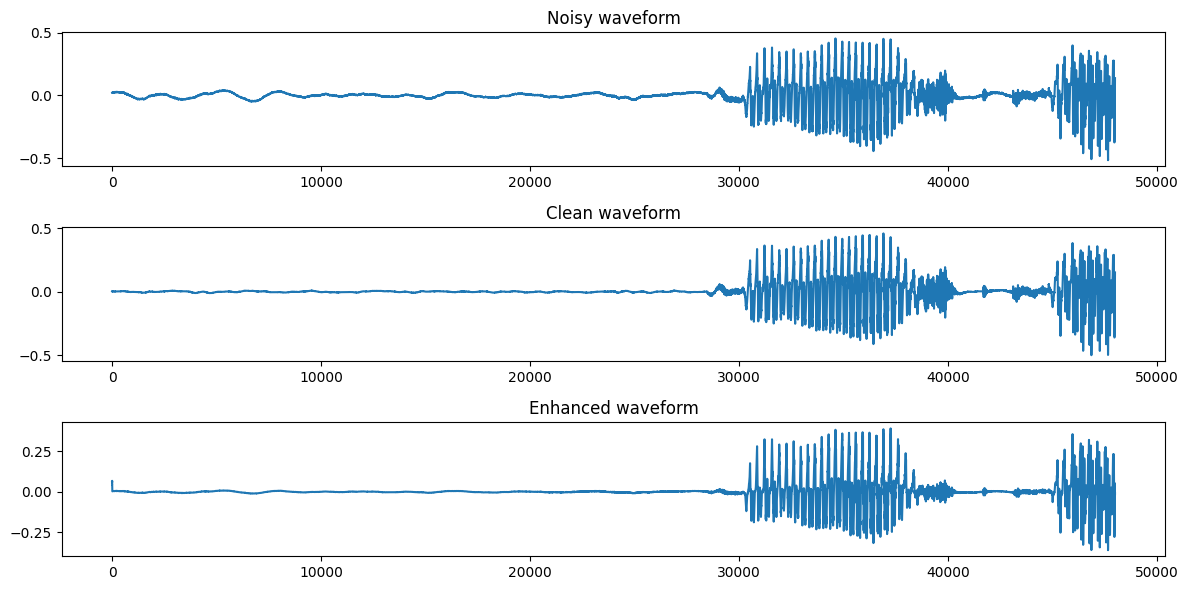

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\functional.py:681: UserWarning: A window was not provided. A rectangular window will be applied,which is known to cause spectral leakage. Other windows such as torch.hann_window or torch.hamming_window are recommended to reduce spectral leakage.To suppress this warning and use a rectangular window, explicitly set `window=torch.ones(n_fft, device=<device>)`. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\SpectralOps.cpp:842.)
  return _VF.stft(  # type: ignore[attr-defined]


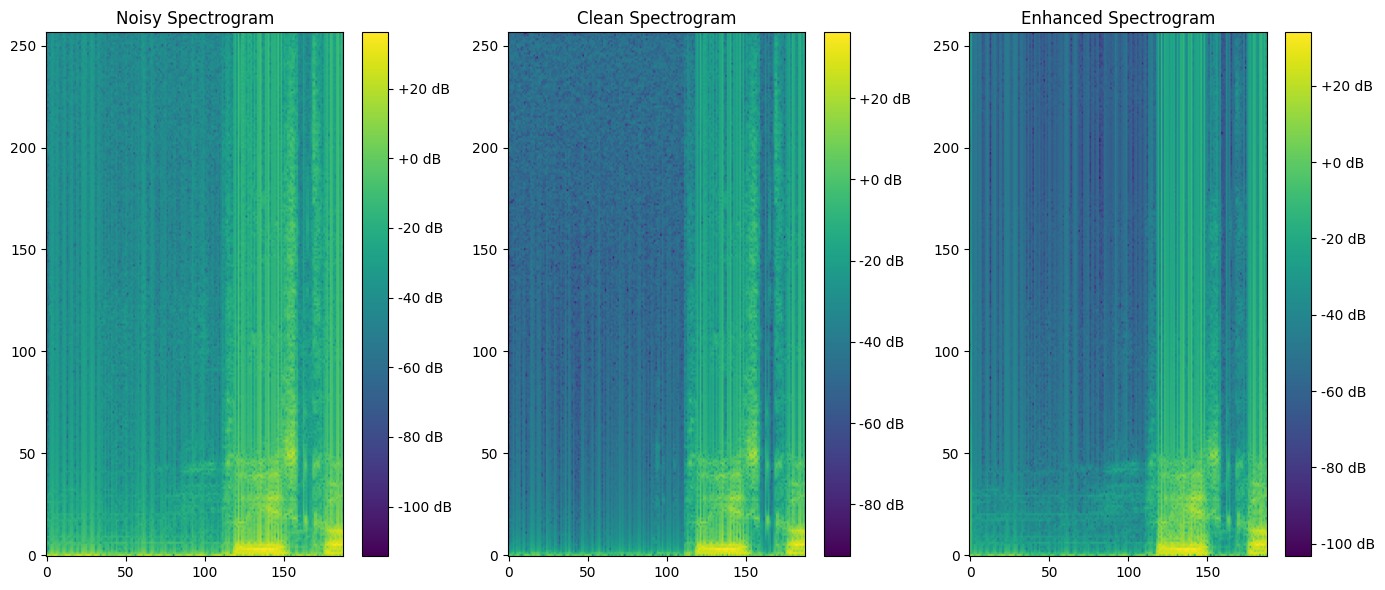

 Saved enhanced audio: ../outputs/enhanced\enhanced_1.wav


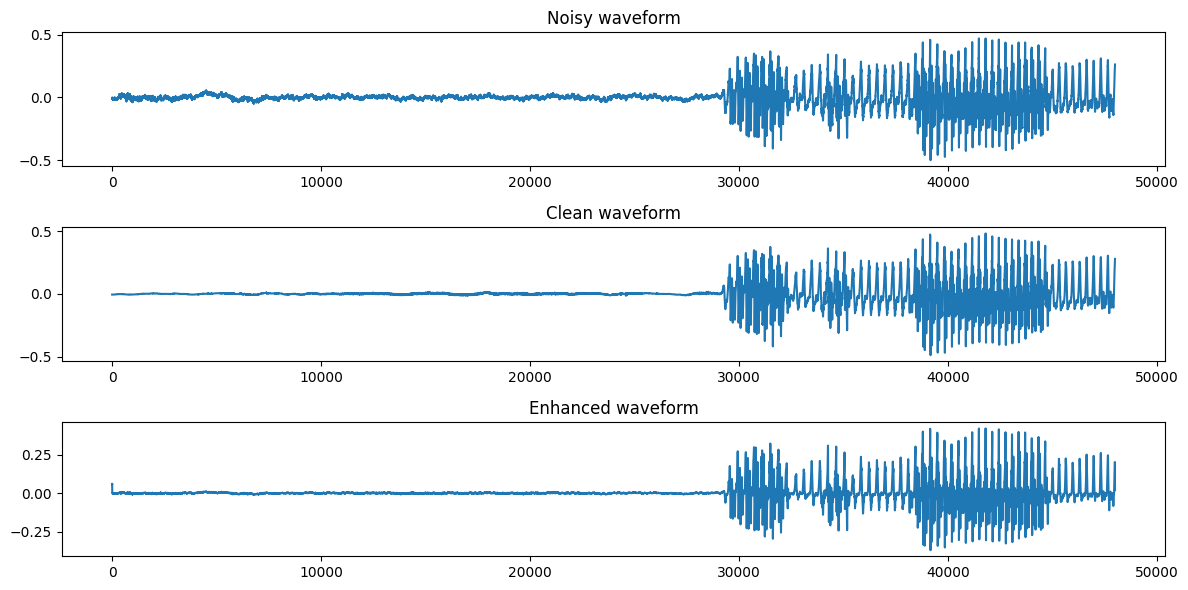

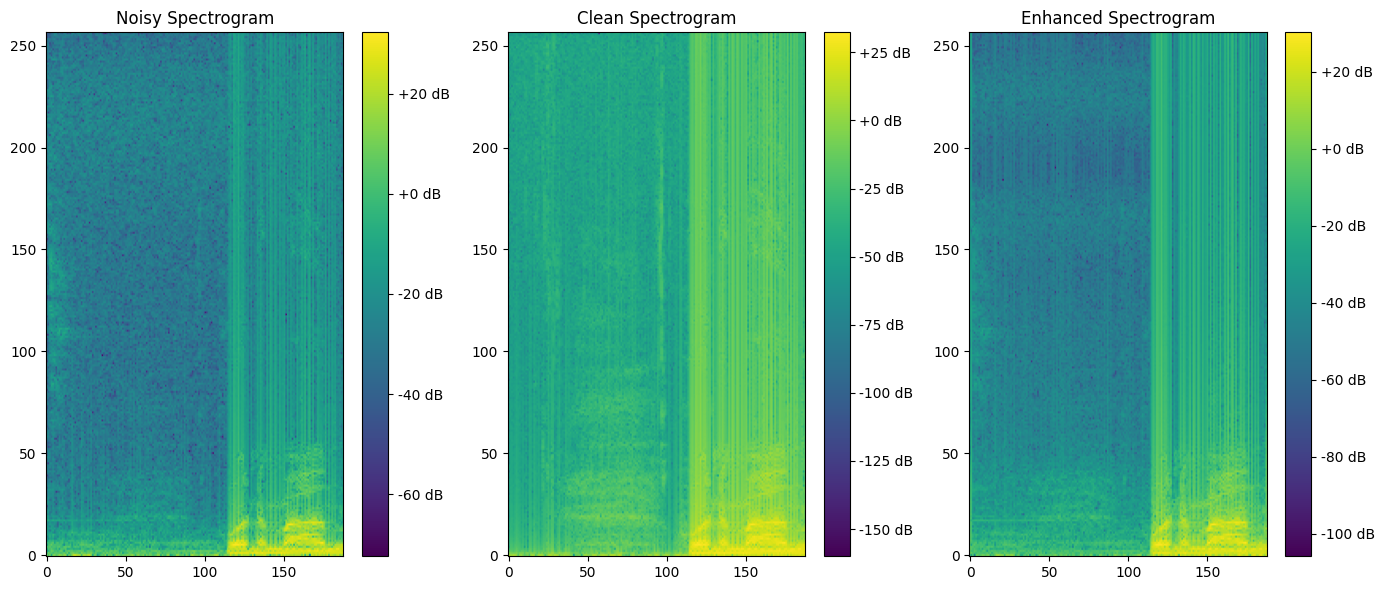

 Saved enhanced audio: ../outputs/enhanced\enhanced_2.wav


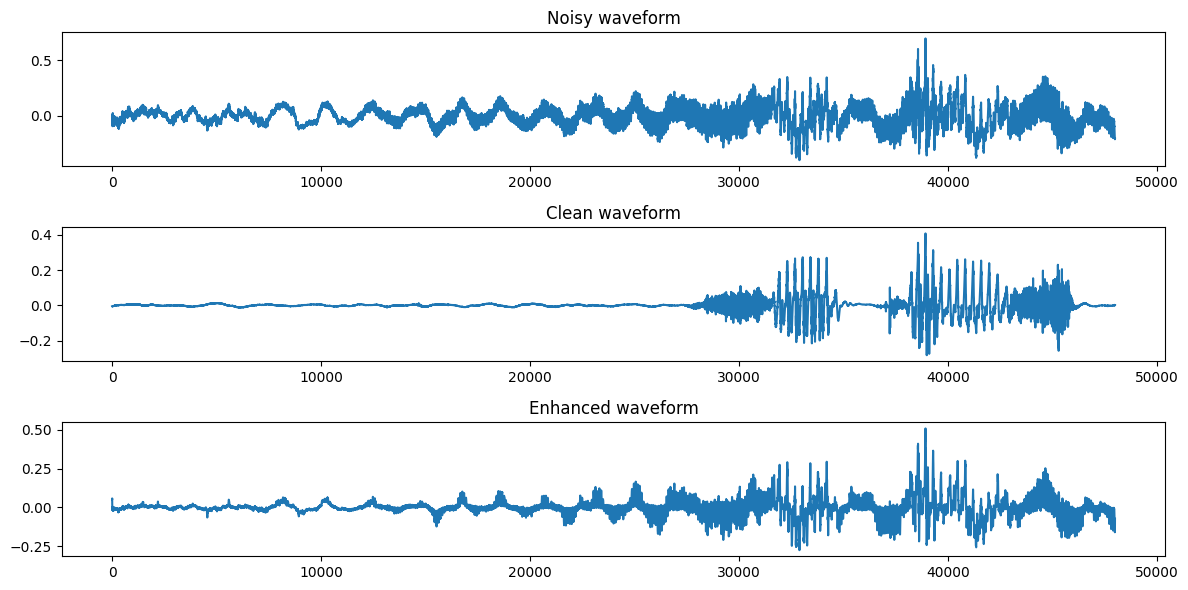

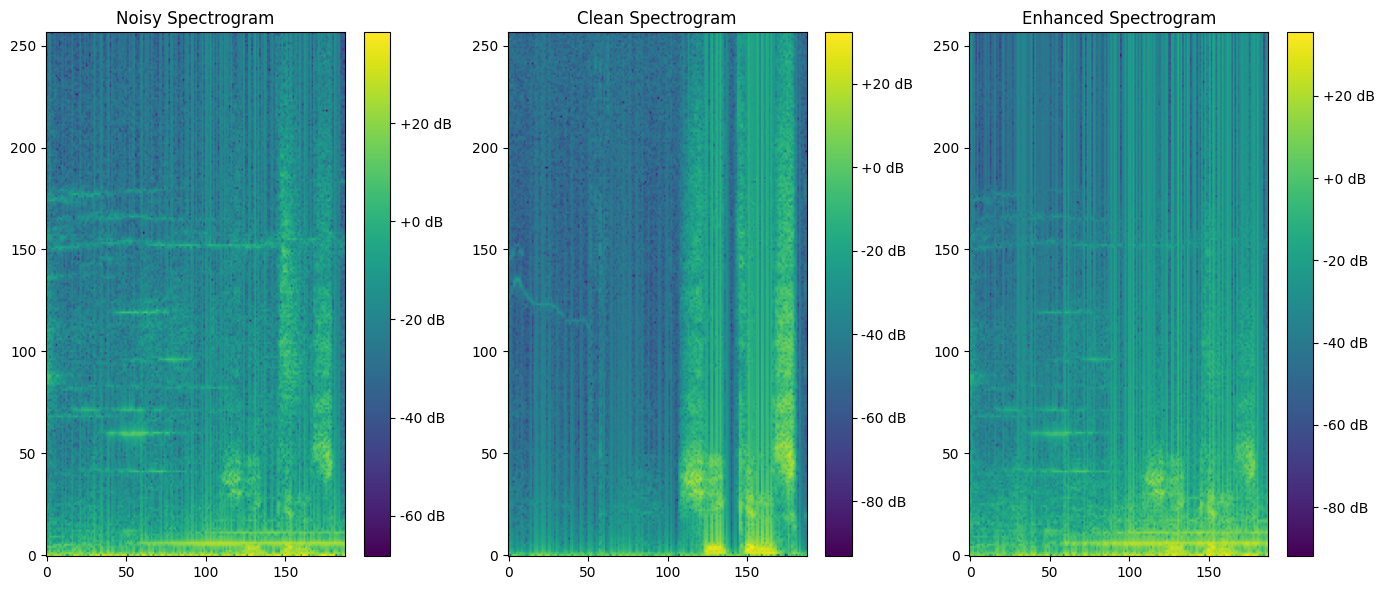

In [2]:

import os
import torch
import torchaudio
import matplotlib.pyplot as plt
import numpy as np
import sys

PROJECT_ROOT = os.path.abspath("..")
if PROJECT_ROOT not in sys.path :
    sys.path.insert(0, PROJECT_ROOT)

from src.model import Conv1DEnhancer, ResNetEnhancer
from src.dataset import SpeechEnhancementDataset


model_type = "Conv1D"  # or "ResNet", "DCCRN"
checkpoint_path = "../outputs/checkpoints/Conv1D_epoch5.pth"
data_dir = "../data"
output_dir = "../outputs/enhanced"
sample_rate = 48000
target_len = 48000
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

os.makedirs(output_dir, exist_ok=True)
print(f"Using device: {device}")


# -----------------------------------
#  Load Model
# -----------------------------------
if model_type == "Conv1D":
    model = Conv1DEnhancer()
elif model_type == "ResNet":
    model = ResNetEnhancer()
elif model_type == "DCCRN":
    model = DCCRN()
else:
    raise ValueError("Invalid model_type")

model.load_state_dict(torch.load(checkpoint_path, map_location=device))
model = model.to(device)
model.eval()

print(f" Loaded model {model_type} from {checkpoint_path}")


# -----------------------------------
#  Prepare test dataset
# -----------------------------------
test_dataset = SpeechEnhancementDataset(
    noisy_dir=os.path.join(data_dir, "N_TS"),
    clean_dir=os.path.join(data_dir, "CL_TS"),
    sample_rate=sample_rate,
    target_len=target_len,
)

indices = np.random.choice(len(test_dataset), 3 , replace=False)

for i, idx in enumerate(indices):
    noisy, clean = test_dataset[idx]
    noisy, clean = noisy.unsqueeze(0).to(device), clean.unsqueeze(0).to(device)

    with torch.no_grad():
        enhanced = model(noisy).squeeze(0).cpu()


    enhanced_path = os.path.join(output_dir, f"enhanced_{i}.wav")
    import soundfile as sf
    sf.write(enhanced_path, enhanced.squeeze().numpy(), sample_rate)
    print(f" Saved enhanced audio: {enhanced_path}")

    # -----------------------------------
    #  Plot waveforms
    # -----------------------------------
    plt.figure(figsize=(12, 6))
    plt.subplot(3, 1, 1)
    plt.title("Noisy waveform")
    plt.plot(noisy.squeeze().cpu().numpy())
    plt.subplot(3, 1, 2)
    plt.title("Clean waveform")
    plt.plot(clean.squeeze().cpu().numpy())
    plt.subplot(3, 1, 3)
    plt.title("Enhanced waveform")
    plt.plot(enhanced.squeeze().numpy())
    plt.tight_layout()
    plt.show()

    # -----------------------------------
    #  Spectrogram comparison
    # -----------------------------------
    def plot_spec(signal, title):
        spec = torch.stft(signal, n_fft=512, hop_length=256, return_complex=True)
        spec_db = 20 * torch.log10(spec.abs() + 1e-8)
        plt.imshow(spec_db.numpy(), aspect="auto", origin="lower")
        plt.title(title)
        plt.colorbar(format="%+2.0f dB")

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 3, 1)
    plot_spec(noisy.squeeze().cpu(), "Noisy Spectrogram")
    plt.subplot(1, 3, 2)
    plot_spec(clean.squeeze().cpu(), "Clean Spectrogram")
    plt.subplot(1, 3, 3)
    plot_spec(enhanced.squeeze(), "Enhanced Spectrogram")
    plt.tight_layout()
    plt.show()


In [ ]:
import os,sys
PROJECT_ROOT = os.path.abspath("..")  
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)


